In [62]:
import pandas as pd
import numpy as np
import re, string

In [63]:
# Load Data Training
data_path = './Sentiment/data_latih.json'
data = pd.read_json(data_path)
data.head()

,akun,id_user,isi,sentimen,tanggal
0,@AhokDjarot,823082326213021696,RT @AhokDjarot: Penasaran sama #BasukiDjarot? ...,netral,Tue Apr 04 14:04:05 +0000 2017
1,@AhokDjarot,3166296157,@AhokDjarot Melayani warga jakarta mulai dari ...,positif,Tue Apr 04 14:00:01 +0000 2017
2,@AhokDjarot,799108167170949121,@Lintank01 @AhokDjarot Golongan sumbu pendek l...,negatif,Tue Apr 04 13:56:37 +0000 2017
3,@AhokDjarot,710566116553166849,RT @RahyaMaya: https://t.co/pvVUIp3YYw Pak Aho...,positif,Tue Apr 04 13:52:44 +0000 2017
4,@AhokDjarot,1335669534,Prof. Edward Omar Sharif H. (Ahli Pidana) : Me...,positif,Tue Apr 04 13:50:01 +0000 2017


In [64]:
#drop netral
data = data[data['sentimen'] != 'netral']
#change label to numerical
factor = pd.factorize(data['sentimen'])
#will be used to change numerical label to actual label
definition = factor[1]
#changing the values of label
data.sentimen = factor[0]
data.head()

,akun,id_user,isi,sentimen,tanggal
1,@AhokDjarot,3166296157,@AhokDjarot Melayani warga jakarta mulai dari ...,0,Tue Apr 04 14:00:01 +0000 2017
2,@AhokDjarot,799108167170949121,@Lintank01 @AhokDjarot Golongan sumbu pendek l...,1,Tue Apr 04 13:56:37 +0000 2017
3,@AhokDjarot,710566116553166849,RT @RahyaMaya: https://t.co/pvVUIp3YYw Pak Aho...,0,Tue Apr 04 13:52:44 +0000 2017
4,@AhokDjarot,1335669534,Prof. Edward Omar Sharif H. (Ahli Pidana) : Me...,0,Tue Apr 04 13:50:01 +0000 2017
5,@AhokDjarot,2357765268,RT @RahyaMaya: https://t.co/pvVUIp3YYw Pak Aho...,0,Tue Apr 04 13:43:59 +0000 2017


In [65]:
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, ArrayDictionary, StopWordRemover
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import re

stop_factory = StopWordRemoverFactory().get_stop_words()

stop_word_list = pd.read_csv('./Sentiment/stopword_list_TALA.txt',header=None)
more_stopword = []
for word in stop_word_list[0]:
    more_stopword.append(word)
# Merge stopword
data_stop_word = stop_factory + more_stopword
dictionary = ArrayDictionary(data_stop_word)
# Create stopword
stopword = StopWordRemover(dictionary)

#create stemmer
stem = StemmerFactory()
stemmer = stem.create_stemmer()

#open keynorm
key_norm = pd.read_csv('./Sentiment/key_norm.csv', )
key_norm_dict = {}
for nonbaku, baku in zip(key_norm['singkat'], key_norm['hasil']):
    key_norm_dict[nonbaku] = baku

In [66]:
def baku_in(text):
    split_text = text.split(" ")
    for word_index in range(len(split_text)):
        if split_text[word_index] in key_norm_dict:
            split_text[word_index] = key_norm_dict[split_text[word_index]]
    return " ".join(split_text)

def prep(text):
    text = stopword.remove(text)
    text = stemmer.stem(text)
    return " ".join(text.split())

def strip_links(text):
    link_regex    = re.compile('((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)', re.DOTALL)
    links         = re.findall(link_regex, text)
    for link in links:
        text = text.replace(link[0], ', ')    
    return text

def strip_all_entities(text):
    entity_prefixes = ['@', '#']
    for separator in  string.punctuation:
        if separator not in entity_prefixes :
            text = text.replace(separator,' ')
    words = []
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in entity_prefixes:
                words.append(word)
    return ' '.join(words)

def pre_processing(tweet_list):
    data_clean = []
    for tw in tweet_list:
        # lowercase
        clean_str = tw.lower() 
        # eliminating username and url
        # clean_str = re.sub(r"(?:\@|https?\://)\S+", " ", clean_str) 
        clean_str = strip_links(clean_str)
        # eliminating hashtags
        clean_str = strip_all_entities(clean_str)
        # removing punctuation
        clean_str = re.sub(r'[^\w\s]',' ',clean_str) 
        # regex for repeating characters
        rpt_regex = re.compile(r"(.)\1{1,}", re.IGNORECASE) 
        clean_str = rpt_regex.sub(r'\1', clean_str)
        # trimming
        clean_str = clean_str.strip() 
        # change non-baku to baku
        clean_str = baku_in(clean_str)
        # removing stowords and stemming
        clean_str = prep(clean_str) 
        # remove unnecessary word
        clean_str = clean_str.replace('btp', '')
        clean_str = clean_str.replace('jakarta', '')
        clean_str = clean_str.replace('dki', '')
        clean_str = clean_str.replace('ahok', '')
        clean_str = clean_str.replace('djarot', '')
        clean_str = clean_str.replace('basuki', '')
        clean_str = clean_str.replace('anies', '')
        clean_str = clean_str.replace('rischa', '')
        clean_str = clean_str.replace('sandi', '')
        clean_str = clean_str.replace('amp', '')
        # removing extra space
        clean_str = re.sub('\s+', ' ', clean_str) 
        data_clean.append(clean_str)
    return data_clean

In [67]:
data['isi'] = data['isi'].astype('str')
data = data.drop_duplicates(subset=['isi'], keep='first')
data['clean'] = pre_processing(data['isi'])
positif = data["clean"][data["sentimen"]==0]
negatif = data["clean"][data["sentimen"]==1]
data = data[(data.clean != '')]
data.head()

,akun,id_user,isi,sentimen,tanggal,clean
1,@AhokDjarot,3166296157,@AhokDjarot Melayani warga jakarta mulai dari ...,0,Tue Apr 04 14:00:01 +0000 2017,layan warga lahir program
2,@AhokDjarot,799108167170949121,@Lintank01 @AhokDjarot Golongan sumbu pendek l...,1,Tue Apr 04 13:56:37 +0000 2017,golong sumbu pendek fpi piaran keluarga cendan...
3,@AhokDjarot,710566116553166849,RT @RahyaMaya: https://t.co/pvVUIp3YYw Pak Aho...,0,Tue Apr 04 13:52:44 +0000 2017,didzolimi bebas
4,@AhokDjarot,1335669534,Prof. Edward Omar Sharif H. (Ahli Pidana) : Me...,0,Tue Apr 04 13:50:01 +0000 2017,prof edward omar sharif ahli pidana pndpt ahli...
6,@AhokDjarot,3970978754,RT @Jakarta_Kece: Pak Ahok Djarot paling kece ...,0,Tue Apr 04 13:43:02 +0000 2017,gaul gaul badai tata kota


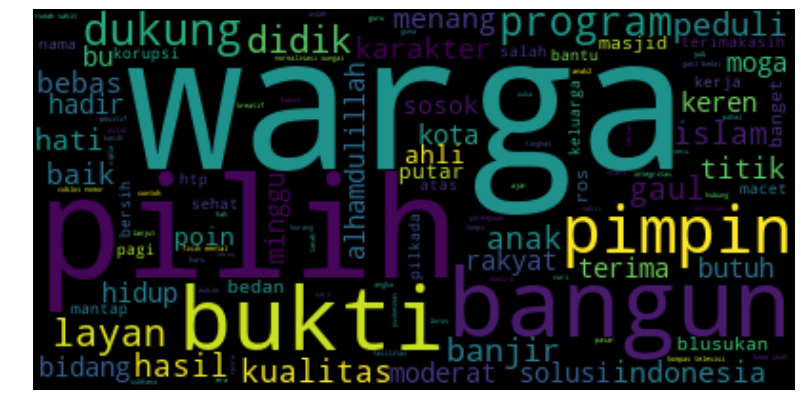

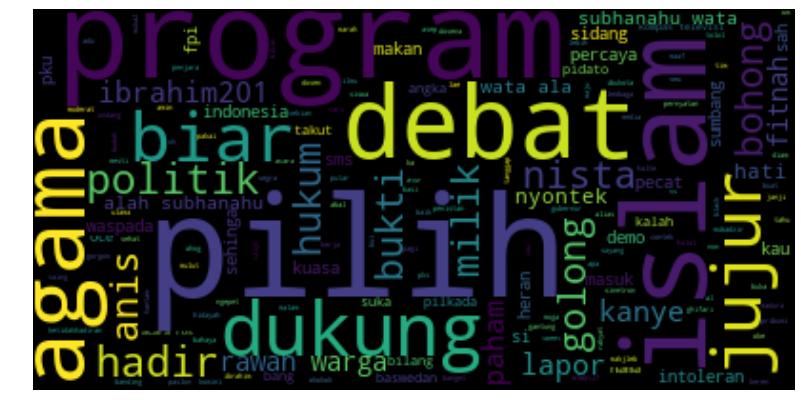

In [68]:
from wordcloud import WordCloud
%matplotlib inline
import matplotlib.pyplot as plt
wordcloud = WordCloud(random_state=21).generate(" ".join(positif))
plt.figure(figsize = (15,7))
plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis("off")
plt.show()
wordcloud = WordCloud(random_state=21).generate(" ".join(negatif))
plt.figure(figsize = (15,7))
plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis("off")
plt.show()

In [69]:
class MNB_TextClassifier:

    def __init__(self):
        self.prior = {}
        self.condprob = {}
        self.word_count_1 = 0
        self.word_count_0 = 0

    # p(class=y | {term0=x[0], term1=x[1], ...} )
    # please note that you dont add new data to vocabulary when predicting
    def proba_y_given_x(self, y, x):
        total_unique_word = len(self.condprob)
        res = self.prior[y]
        if y == 1:
            for elem_x in x:
                if elem_x in self.condprob:
                    res *= self.condprob[elem_x][y]
                else:
                    res *= 1 / (self.word_count_1 + total_unique_word)
        else:
            for elem_x in x:
                if elem_x in self.condprob:
                    res *= self.condprob[elem_x][y]
                else:
                    res *= 1 / (self.word_count_0 + total_unique_word)
        return res

    # p(c)
    def proba_y(self, y):

        return self.prior[y]

    # update self.prior[class] as p(class=class) 
    # update self.condprob[term][class] as p(term=term | class=class)
    def fit(self, X, y):
        # initial value
        for i in range(0, 2):
            self.prior[i] = 0
        total = len(y)
        # update self.prior[class] as p(class=class)
        for elem_y in y:
            self.prior[elem_y] += 1
        for key in self.prior:
            self.prior[key] /= total

        # update self.condprob[term][class] as p(term=term | class=class)
        distinct_word_1 = {}
        distinct_word_0 = {}
        distinct_word = set()
        self.word_count_1 = 0
        self.word_count_0 = 0
        for x in zip(X, y):
            for elem_x in x[0]:
                distinct_word.add(elem_x)
                if x[1] == 1:
                    self.word_count_1 += 1
                    if (elem_x, x[1]) not in distinct_word_1:
                        distinct_word_1[(elem_x, x[1])] = 1
                    else:
                        distinct_word_1[(elem_x, x[1])] += 1
                else:
                    self.word_count_0 += 1
                    if (elem_x, x[1]) not in distinct_word_0:
                        distinct_word_0[(elem_x, x[1])] = 1
                    else:
                        distinct_word_0[(elem_x, x[1])] += 1

        for word in distinct_word:
            self.condprob[word] = {}
        distinct_word_length = len(distinct_word)

        for key in distinct_word_0.keys():
            word = key[0]
            word_class = key[1]

            self.condprob[word][word_class] = (distinct_word_0[key] + 1) / (distinct_word_length + self.word_count_0)
        for key in distinct_word_1.keys():
            word = key[0]
            word_class = key[1]
            self.condprob[word][word_class] = (distinct_word_1[key] + 1) / (distinct_word_length + self.word_count_1)

        for word in distinct_word:
            if 1 not in self.condprob[word].keys():
                self.condprob[word][1] = (0 + 1) / (distinct_word_length + self.word_count_1)
            elif 0 not in self.condprob[word].keys():
                self.condprob[word][0] = (0 + 1) / (distinct_word_length + self.word_count_0)

    def predict_single(self, x):
        if self.proba_y_given_x(1, x) > self.proba_y_given_x(0, x):
            return 1
        else:
            return 0

    def predict(self, X):
        return [self.predict_single(x) for x in X]

In [70]:
from random import seed
from random import randrange
 
# Split a dataset into a train and test set
def train_test_split(dataset, split=0.80):
    train = list()
    train_size = split * len(dataset)
    dataset_copy = list(dataset)
    while len(train) < train_size:
        index = randrange(len(dataset_copy))
        train.append(dataset_copy.pop(index))
    test = dataset_copy
    X_train = []
    X_test = []
    y_train = []
    y_test = []
    for elem in train:
        X_train.append(elem[0])
        y_train.append(elem[1])
    for elem in test:
        X_test.append(elem[0])
        y_test.append(elem[1])
    return X_train, y_train, X_test, y_test

In [71]:
def get_accuracy(clf, X_test, y_test):
    y_pred = clf.predict(X_test)
    total = len(y_pred)
    true_pos = 0
    true_neg = 0
    for idx in range(total):
        if y_pred[idx] == y_test[idx]:
            if y_pred[idx] == 1:
                true_pos+= 1
            else:
                true_neg+= 1
    accuracy = (true_pos + true_neg) / total
    return accuracy

In [72]:
# test train/test split
seed(1)
# print(data['clean'])
data_arr = []
for elem in data['clean']:
    data_arr.append(elem.strip().split(" "))

X = np.array(data_arr)
y = np.array(data['sentimen'])
new_dataset = []
for elem in zip(X, y):
    new_dataset.append(elem)
X_train, y_train, X_test, y_test = train_test_split(new_dataset, 0.75)
clf = MNB_TextClassifier()
clf.fit(X_train, y_train)
accuracy = get_accuracy(clf, X_test, y_test)
print(accuracy)

0.7040816326530612


In [73]:
def prediction_pre_processing(tweet_list):
    data_clean = []
    for tw in tweet_list:
        # lowercase
        clean_str = tw.lower() 
        # eliminating username and url
        # clean_str = re.sub(r"(?:\@|https?\://)\S+", " ", clean_str) 
        clean_str = strip_links(clean_str)
        # eliminating hashtags
        clean_str = strip_all_entities(clean_str)
        # removing punctuation
        clean_str = re.sub(r'[^\w\s]',' ',clean_str) 
        # regex for repeating characters
        rpt_regex = re.compile(r"(.)\1{1,}", re.IGNORECASE) 
        clean_str = rpt_regex.sub(r'\1', clean_str)
        # trimming
        clean_str = clean_str.strip() 
        # change non-baku to baku
        clean_str = baku_in(clean_str)
        # removing stowords and stemming
        clean_str = prep(clean_str) 
        # remove unnecessary word
        # removing extra space
        clean_str = re.sub('\s+', ' ', clean_str) 
        data_clean.append(clean_str)
    return data_clean

In [86]:
#prabowo_sentiment = np.array(pd.read_csv('prabowo_dataset.txt', header=None)[0])
jokowi_data = pd.read_csv('jokowi_dataset.txt', sep='`')
jokowi_dataset = np.array(jokowi_data['tweet'])
jokowi_data.head()

,tweet
0,@noldeforestasi @jokowi @RamliRizal @FaisalBas...
1,@VIVAcoid Hasil revolusi mental nih pak @jokowi
2,"@vintenas ""Jokowi dianggap gagal menyelesaikan..."
3,@pennyhepiyani @marakupberasa @ustadtengkuzul ...
4,"RT @jokowi: Mendarat di ""kawasan segitiga"" Kal..."


In [88]:
prabowo_data = pd.read_csv('prabowo_dataset.txt', sep='`')
prabowo_dataset = np.array(prabowo_data['tweet'])
prabowo_data.head()

,tweet
0,Prabowo ingin jenazah petugas KPPS divisum
1,https://t.co/GY8XFoFz1l
2,Prabowo: Pernyataan Hendropriyono Rasis Dan Ad...
3,RT @Nadiku18: Sekali @prabowo tetap Prabowo. M...
4,Hanya ada satu…


In [89]:
clean_jokowi_sentiment = prediction_pre_processing(jokowi_dataset)
clean_prabowo_sentiment = prediction_pre_processing(prabowo_dataset)

In [90]:
pred_jokowi, pred_prabowo = [], []
for elem in clean_jokowi_sentiment:
    if elem != '':
        pred_jokowi.append(elem.split(" "))
for elem in clean_prabowo_sentiment:
    if elem != '':
        pred_prabowo.append(elem.split(" "))

In [91]:
label_jokowi = clf.predict(pred_jokowi)
label_prabowo = clf.predict(pred_prabowo)

In [92]:
def calculate_reputation(labels):
    length = len(labels)
    res = 0
    for elem in labels:
        res += elem
    res = res/length*100
    return res

In [94]:
print('Reputasi Jokowi: %f' % calculate_reputation(label_jokowi))
print('Reputsi Prabowo: %f' % calculate_reputation(label_prabowo))

Reputasi Jokowi: 57.627119
Reputsi Prabowo: 65.217391
